# Bag-of-words document classification

* BoW is the simplest way to do classification: Feature vector goes in, decision falls out.

* Feature vector: a vector with as many dimensions as we have unique features, and a non-zero value set for every feature present in our example
* Binary features: 1/0

In the following we work with the IMDB data, have a look on [how to read it in](read_imdb.ipynb). Here we just read the ready data in.

# IMDB data

* Movie review sentiment positive/negative
* Some 25,000 examples, 50:50 split
* Current state-of-the-art is about 95% accuracy


In [1]:
import json
import random
with open("data/imdb_train.json") as f:
    data=json.load(f)
random.shuffle(data) #play it safe!
print(data[0]) #Every item is a dictionary with `text` and `class` keys, here's the first one:

{'text': "I'm not a Steve Carell fan however I like this movie about Dan, an advice columnist, who goes to his parents house for a stay with his kids and ends up falling in love with his brother's girlfriend. Its a story thats been told before, but not like this. There are simply too many little bits that make the film better than it should be. The cast is wonderful, and even if Carell is not my cup of tea, he is quite good as the widower who's suppose to know everything but finds that knowing is different than feeling and that sometimes life surprises you. At times witty and wise in the way that an annoying Hallmark card can be, the film still some how manages to grow on you and be something more than a run of the mill film. Worth a look see", 'class': 'pos'}


To learn on this data, we will need a few steps:

* Build a data matrix with dimensionality (number of examples, number of possible features), and a value for each feature, 0/1 for binary features
* Build a class label matrix (number of examples, number of classes) with the correct labels for the examples, setting 1 for the correct class, and 0 for others

It is quite useless to do all this ourselves, so we will use ready-made classes and functions mostly from scikit

In [2]:
# We need to gather the texts, into a list
texts=[one_example["text"] for one_example in data]
labels=[one_example["class"] for one_example in data]
print(texts[:2])
print(labels[:2])

["I'm not a Steve Carell fan however I like this movie about Dan, an advice columnist, who goes to his parents house for a stay with his kids and ends up falling in love with his brother's girlfriend. Its a story thats been told before, but not like this. There are simply too many little bits that make the film better than it should be. The cast is wonderful, and even if Carell is not my cup of tea, he is quite good as the widower who's suppose to know everything but finds that knowing is different than feeling and that sometimes life surprises you. At times witty and wise in the way that an annoying Hallmark card can be, the film still some how manages to grow on you and be something more than a run of the mill film. Worth a look see", 'Once in a while, a film comes along that raises the bar for every other film in its genre. A film of this caliber will influence many films following its release for years to come. `A Chinese Ghost Story\' falls in this category. It is arguably one of 

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer=CountVectorizer(max_features=100000,binary=True,ngram_range=(1,1))
feature_matrix=vectorizer.fit_transform(texts)
print("shape=",feature_matrix.shape)


shape= (25000, 74849)


Now we have the feature matrix done! Next thing we need is the class labels to be predicted in one-hot encoding. This means:

* one row for every example
* one column for every possible class label
* exactly one column has 1 for every example, corresponding to the desired class

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder=LabelEncoder() #Turns class labels into integers
one_hot_encoder=OneHotEncoder(sparse=False) #Turns class integers into one-hot encoding
class_numbers=label_encoder.fit_transform(labels)
print("class_numbers shape=",class_numbers.shape)
print("class labels",label_encoder.classes_) #this will let us translate back from indices to labels
#And now yet the one-hot encoding
classes_1hot=one_hot_encoder.fit_transform(class_numbers.reshape(-1,1)) #running without reshape tells you to reshape
print("classes_1hot",classes_1hot)

class_numbers shape= (25000,)
class labels ['neg' 'pos']
classes_1hot [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


* The data is ready, we need to build the network now
* Input
* Hidden Dense layer with some kind of non-linearity, and a suitable number of nodes
* Output Dense layer with the softmax activation (normalizes output to distribution) and as many nodes as there are classes

In [5]:
from keras.models import Model
from keras.layers import Input, Dense

example_count,feature_count=feature_matrix.shape
example_count2,class_count=classes_1hot.shape
assert example_count==example_count2 #sanity check

inp=Input(shape=(feature_count,))
hidden=Dense(200,activation="tanh")(inp)
outp=Dense(class_count,activation="softmax")(hidden)
model=Model(inputs=[inp], outputs=[outp])

/home/ginter/venv-jupyter/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


...it's **this** simple...!

Once the model is constructed it needs to be compiled, for that we need to know:
* which optimizer we want to use (sgd is fine to begin with)
* what is the loss (categorial_crossentropy for multiclass of the kind we have is the right choice)
* which metrics to measure, accuracy is an okay choice

In [6]:
model.compile(optimizer="sgd",loss="categorical_crossentropy",metrics=['accuracy'])

A compiled model can be fitted on data:

In [7]:
hist=model.fit(feature_matrix,classes_1hot,batch_size=100,verbose=1,epochs=10,validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 13s 578us/step - loss: 0.5685 - acc: 0.7732 - val_loss: 0.4884 - val_acc: 0.8256
Epoch 2/10
22500/22500 [==============================] - 12s 533us/step - loss: 0.4382 - acc: 0.8363 - val_loss: 0.4158 - val_acc: 0.8488
Epoch 3/10
22500/22500 [==============================] - 13s 574us/step - loss: 0.3790 - acc: 0.8556 - val_loss: 0.3793 - val_acc: 0.8572
Epoch 4/10
22500/22500 [==============================] - 11s 495us/step - loss: 0.3440 - acc: 0.8658 - val_loss: 0.3572 - val_acc: 0.8604
Epoch 5/10
22500/22500 [==============================] - 12s 547us/step - loss: 0.3200 - acc: 0.8745 - val_loss: 0.3424 - val_acc: 0.8648
Epoch 6/10
22500/22500 [==============================] - 14s 613us/step - loss: 0.3013 - acc: 0.8815 - val_loss: 0.3323 - val_acc: 0.8652
Epoch 7/10
22500/22500 [==============================] - 12s 525us/step - loss: 0.2859 - acc: 0.8892 - val_loss: 0.3

In [8]:
print(hist.history["val_acc"])

[0.8255999970436096, 0.8488000011444092, 0.8572000002861023, 0.8603999996185303, 0.8647999954223633, 0.8651999974250794, 0.8700000023841858, 0.8720000004768371, 0.8735999941825867, 0.8739999938011169]


* We ran for 10 epochs of training
* Made it to 88.7% accuracy on the validation and 94.9% accuracy on the training data

* But we do not have the model saved, so let's fix that and get the whole thing done
* What constitutes a model (ie what we need to run the model on new data)
  - The feature dictionary in the vectorizer
  - The list of classes in their correct order
  - The structure of the network
  - The weights the network learned

* Do all these things, and run again. This time we also increase the number of epochs to 100, see what happens.

In [24]:
import h5py
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint

def save_model(file_name,model,label_encoder,vectorizer):
    """Saves model structure and vocabularies"""
    model_json = model.to_json()
    with open(file_name+".model.json", "w") as f:
        print(model_json,file=f)
    with open(file_name+".vocabularies.json","w") as f:
        classes=list(label_encoder.classes_)
        vocab=dict(((str(w),int(idx)) for w,idx in vectorizer.vocabulary_.items())) #must turn numpy objects to python ones
        json.dump((classes,vocab),f,indent=2)
        
example_count,feature_count=feature_matrix.shape
example_count2,class_count=classes_1hot.shape
assert example_count==example_count2 #sanity check

inp=Input(shape=(feature_count,))
hidden=Dense(200,activation="tanh")(inp)
outp=Dense(class_count,activation="softmax")(hidden)
model=Model(inputs=[inp], outputs=[outp])
model.compile(optimizer="sgd",loss="categorical_crossentropy",metrics=['accuracy'])

# Save model and vocabularies, can be done before training
save_model("models/imdb_bow",model,label_encoder,vectorizer)
# Callback function to save weights during training, if validation loss goes down
save_cb=ModelCheckpoint(filepath="models/imdb_bow.weights.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

hist=model.fit(feature_matrix,classes_1hot,batch_size=100,verbose=1,epochs=100,validation_split=0.1,callbacks=[save_cb])


Train on 22500 samples, validate on 2500 samples
Epoch 1/100
22500/22500 [==============================] - 19s 827us/step - loss: 0.5680 - acc: 0.7744 - val_loss: 0.4902 - val_acc: 0.8248

Epoch 00001: val_loss improved from inf to 0.49017, saving model to models/imdb_bow.weights.h5
Epoch 2/100
22500/22500 [==============================] - 25s 1ms/step - loss: 0.4374 - acc: 0.8370 - val_loss: 0.4154 - val_acc: 0.8476

Epoch 00002: val_loss improved from 0.49017 to 0.41538, saving model to models/imdb_bow.weights.h5
Epoch 3/100
22500/22500 [==============================] - 33s 1ms/step - loss: 0.3786 - acc: 0.8541 - val_loss: 0.3788 - val_acc: 0.8560

Epoch 00003: val_loss improved from 0.41538 to 0.37884, saving model to models/imdb_bow.weights.h5
Epoch 4/100
22500/22500 [==============================] - 23s 1ms/step - loss: 0.3436 - acc: 0.8667 - val_loss: 0.3569 - val_acc: 0.8656

Epoch 00004: val_loss improved from 0.37884 to 0.35686, saving model to models/imdb_bow.weights.h5
E

22500/22500 [==============================] - 12s 555us/step - loss: 0.1152 - acc: 0.9663 - val_loss: 0.3142 - val_acc: 0.8780

Epoch 00040: val_loss did not improve
Epoch 41/100
22500/22500 [==============================] - 12s 550us/step - loss: 0.1127 - acc: 0.9681 - val_loss: 0.3155 - val_acc: 0.8796

Epoch 00041: val_loss did not improve
Epoch 42/100
22500/22500 [==============================] - 13s 557us/step - loss: 0.1102 - acc: 0.9688 - val_loss: 0.3173 - val_acc: 0.8800

Epoch 00042: val_loss did not improve
Epoch 43/100
22500/22500 [==============================] - 13s 559us/step - loss: 0.1079 - acc: 0.9704 - val_loss: 0.3195 - val_acc: 0.8788

Epoch 00043: val_loss did not improve
Epoch 44/100
22500/22500 [==============================] - 12s 551us/step - loss: 0.1055 - acc: 0.9712 - val_loss: 0.3227 - val_acc: 0.8776

Epoch 00044: val_loss did not improve
Epoch 45/100
22500/22500 [==============================] - 12s 553us/step - loss: 0.1036 - acc: 0.9718 - val_los


Epoch 00085: val_loss did not improve
Epoch 86/100
22500/22500 [==============================] - 26s 1ms/step - loss: 0.0468 - acc: 0.9933 - val_loss: 0.3970 - val_acc: 0.8740

Epoch 00086: val_loss did not improve
Epoch 87/100
22500/22500 [==============================] - 23s 1ms/step - loss: 0.0458 - acc: 0.9935 - val_loss: 0.3984 - val_acc: 0.8744

Epoch 00087: val_loss did not improve
Epoch 88/100
22500/22500 [==============================] - 27s 1ms/step - loss: 0.0451 - acc: 0.9936 - val_loss: 0.4000 - val_acc: 0.8724

Epoch 00088: val_loss did not improve
Epoch 89/100
22500/22500 [==============================] - 32s 1ms/step - loss: 0.0443 - acc: 0.9934 - val_loss: 0.4019 - val_acc: 0.8732

Epoch 00089: val_loss did not improve
Epoch 90/100
22500/22500 [==============================] - 13s 594us/step - loss: 0.0436 - acc: 0.9940 - val_loss: 0.4033 - val_acc: 0.8740

Epoch 00090: val_loss did not improve
Epoch 91/100
22500/22500 [==============================] - 12s 546us

In [25]:
import numpy
from sklearn.metrics import classification_report, confusion_matrix

#Validation data used during training:
val_instances,val_labels_1hot,_=hist.validation_data

print("Network output=",model.predict(val_instances))
predictions=numpy.argmax(model.predict(val_instances),axis=1)
print("Maximum class for each example=",predictions)
gold=numpy.nonzero(val_labels_1hot)[1] #undo 1-hot encoding
conf_matrix=confusion_matrix(list(gold),list(predictions))
print("Confusion matrix=\n",conf_matrix)
print(classification_report(list(gold),list(predictions),target_names=label_encoder.classes_))

Network output= [[1.8448678e-05 9.9998152e-01]
 [9.9508435e-01 4.9155969e-03]
 [9.6974520e-07 9.9999905e-01]
 ...
 [2.8421250e-01 7.1578753e-01]
 [1.3249072e-01 8.6750925e-01]
 [2.1320222e-06 9.9999785e-01]]
Maximum class for each example= [1 0 1 ... 1 1 1]
Confusion matrix=
 [[1101  157]
 [ 156 1086]]
             precision    recall  f1-score   support

        neg       0.88      0.88      0.88      1258
        pos       0.87      0.87      0.87      1242

avg / total       0.87      0.87      0.87      2500



# Learning progress

* The history object we get lets us inspect the accuracy during training
* Remarks:
  - Accuracy on training data keeps going up
  - Accuracy on validation (test) data flattens out after a but over 10 epochs, we are learning very little past that point
  - What we see is the network keeps overfitting on the training data to the end

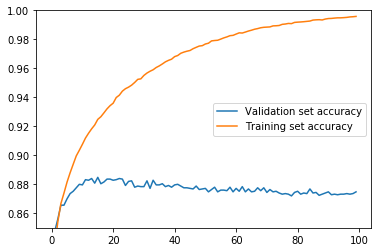

In [28]:
import matplotlib.pyplot as plt
#print(hist.history["val_acc"])
plt.ylim(0.85,1.0)
plt.plot(hist.history["val_acc"],label="Validation set accuracy")
plt.plot(hist.history["acc"],label="Training set accuracy")
plt.legend()
plt.show()

# Summary

* We put together a program to train a neural network classifier for sentiment detector
* We learned the necessary code/techniques to save models, and feed the training with data in just the right format
* We observed the training across epochs
* We saw how the classifier can be applied to various text classification problems
* The IMDB sentiment classifier ended up at nearly 90% accuracy, the state of the art is about 95%, we got surprisingly far in few lines of code
